<b>K-Means Clustering Example #2</b><br/>
In this notebook, we will look at how we can visualize the results of k-means clustering on a set of molecules. The dataset here is 10 sets of 100 structures taken from this paper https://pubs.acs.org/doi/10.1021/acs.jcim.8b00542. Each set of 100 consists of molecules reported to bind to a particular biological target. <br/>
The input was created using the command <br>
<pre>kmeans.py all --in bender.smi --clusters 25 --out clusters.csv</pre>

We will visualized the results of the clustering as a heatmap and create an interactive tool for visualizing the molecules associated with each target.  

To run this notebook you'll need a few libraries.  The commands to install these libraries are below<br>
<pre>
conda create -c rdkit -n my-rdkit-env rdkit
conda install -c conda-forge ipywidgets jupyter
pip install numpy pandas seaborn matplotlib
</pre>
After this you can fire up this notebook.<br/>
<pre>
source activate my-rdkit-env
jupyter notebook kmeans_example2.ipynb
</pre>

Import libraries, the ipywidgets library gives us the interactive functionality below.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Read the input data and write the first few lines as a sanity check.  

In [3]:
df = pd.read_csv("bender_clusters.csv")
df.head()

,SMILES,Name,Cluster
0,CNCC1CC2c3ccccc3Cc3ccccc3N2O1,A2a_000,0
1,CN(C)CC1CC2c3ccccc3Cc3ccccc3N2O1,A2a_001,0
2,CN1CCN2c3ccccc3Cc3ccccc3C2C1,A2a_002,0
3,CN(C)CC1CC2c3ccccc3Cc3ccc(Cl)cc3N2O1,A2a_003,0
4,CC(N)Cc1c[nH]c2ccc3c(c12)CCCO3,A2a_004,19


Add a "Target" column to the dataframe by splitting the "Name" field on "_"

In [4]:
df['Target'] = [x.split("_")[0] for x in df.Name]
df.sort_values("Cluster",inplace=True)

Create a dictionary mapping targets to their integer order

In [5]:
unique_targets = df.Target.unique()
target_dict = dict([(x,y) for x,y in zip(unique_targets,range(0,len(unique_targets)))])
num_targets = len(unique_targets)
target_dict

{'A2a': 0,
 'B-raf': 1,
 'Acetylcholinesterase': 2,
 'ABL1': 3,
 'Aurora-A': 4,
 'Cannabinoid': 5,
 'Carbonic': 6,
 'COX-1': 7,
 'COX-2': 8,
 'Caspase': 9}

Create a matrix with targets in rows and clusters in columns. For each target, put the number of molecules in each cluster in the corresponding matrix cell. 

In [6]:
mat = []
for k,v in df.groupby("Cluster"):
    row_vec = np.zeros(num_targets,dtype=np.int8)
    for tgt,count in v.Target.value_counts().iteritems():
        tgt_idx = target_dict[tgt]
        row_vec[tgt_idx] = count
    mat.append(row_vec)
mat = np.array(mat)
out_df = pd.DataFrame(mat.transpose())
out_df.insert(0,"Target",unique_targets)
out_df

,Target,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,A2a,9,0,0,0,0,0,0,47,1,...,13,0,0,0,6,0,0,0,1,3
1,B-raf,43,1,0,0,37,0,0,1,0,...,0,0,0,0,0,0,1,0,17,0
2,Acetylcholinesterase,1,0,0,0,0,0,25,0,0,...,6,17,13,0,13,0,0,0,4,0
3,ABL1,3,0,0,1,0,0,0,4,0,...,3,0,22,0,1,0,42,0,20,4
4,Aurora-A,4,0,0,3,0,0,0,43,0,...,0,0,0,0,3,0,11,0,12,0
5,Cannabinoid,0,41,0,1,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0
6,Carbonic,0,0,86,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,COX-1,0,0,0,18,0,0,0,0,12,...,12,0,0,0,1,19,0,27,0,0
8,COX-2,0,0,0,4,0,0,0,0,15,...,32,0,0,0,5,1,0,31,1,0
9,Caspase,0,0,0,0,0,50,0,0,0,...,0,0,0,24,0,0,0,0,0,0


The matrix above isn't a great visualization, let's make a heatmap.  In order to reduce the visual noise in the heatmap (too many zeros), we will replace the zeros with np.nan (numpy null value). 

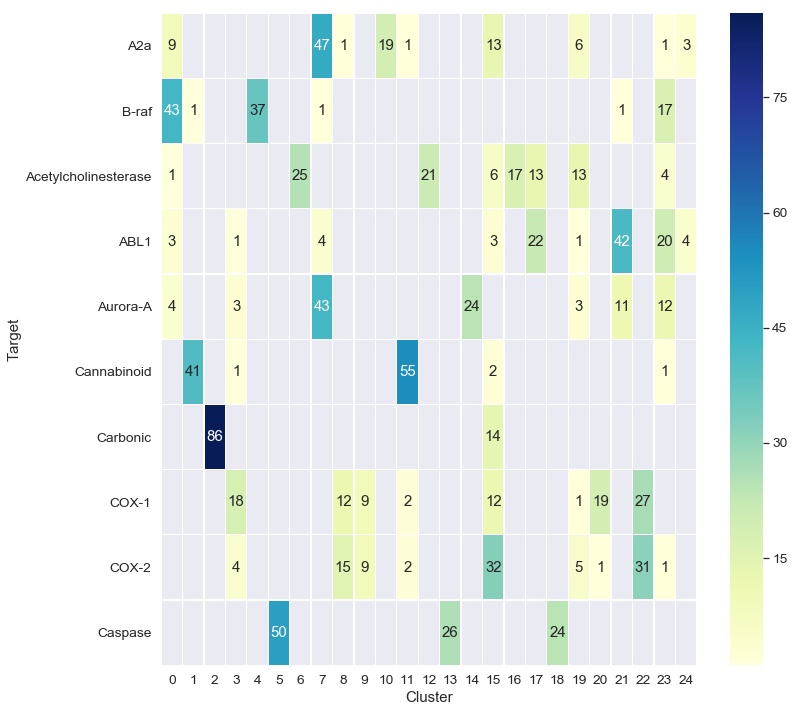

In [7]:
sns.set(rc={'figure.figsize':(12,12)})
sns.set(font_scale=1.25)
hm_df = pd.DataFrame(np.array(out_df.values[0::,1::],dtype=np.int8))
hm_df.replace(0,np.nan,inplace=True)
ax = sns.heatmap(hm_df,annot=True,yticklabels=unique_targets,linewidths=0.25,cmap="YlGnBu")
settings = ax.set(xlabel='Cluster', ylabel='Target')

Now let's create an interactive visualization tha allows us to look at how the molecules are clustered for each target.  This was inspired by Greg Landrum's blog post http://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html.  The numbers below the structures are the cluster ids. The data is sorted by cluster id. 

In [8]:
def display_mols(target):
    sel = df.query(f"Target == '{target}'")
    smi_list = list(sel.SMILES)
    cluster_list = [str(x) for x in sel.Cluster]
    display(Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in smi_list],molsPerRow=5,legends=cluster_list))

In [9]:
res = interact(display_mols,target=unique_targets)

interactive(children=(Dropdown(description='target', options=('A2a', 'B-raf', 'Acetylcholinesterase', 'ABL1', …